In [ ]:
#@markdown Configuración Inicial

import os, sys
from IPython.utils import io
from IPython.display import display, display_svg
from IPython.display import Math, Latex
from IPython.display import IFrame, HTML
import time
from datetime import datetime as dt
from pytz import timezone
import random, string

prefix = 'Serialpc' # Serialpc, Parallel
configdict = {
    'Serialpc': "DISABLE_JIT: 1",
    'Parallel': "DISABLE_JIT: 0\n"
                "NUM_THREADS: 2\n"
                "THREADING_LAYER: 'tbb'"
}

################################################################################

workdir = prefix +\
          dt.now(timezone('America/Bogota')).\
          strftime('_%y%m%d-%H%M_') +\
          ''.join(random.sample(string.hexdigits, 4)
          )
os.mkdir(workdir)
os.chdir(workdir)
print('Working Directory:', os.getcwd(), sep='\n')
with open('.numba_config.yaml','w') as cf:
  cf.write(configdict[prefix])
  print('Numba Config:', 
        configdict[prefix], 
        sep='\n', end='\n\n')

################################################################################

# https://stackoverflow.com/a/57883792
# https://stackoverflow.com/a/57113015
with io.capture_output() as cap:
  !pip install tbb
  !pip install setuptools
  # https://github.com/lycantropos/bentley_ottmann
  # http://geomalgorithms.com/a09-_intersect-3.html#Shamos-Hoey-Algorithm
  # http://euro.ecom.cmu.edu/people/faculty/mshamos/1976GeometricIntersection.pdf
  !pip install bentley_ottmann
  # https://matplotlib-axes-aligner.readthedocs.io/en/latest/
  !pip install mpl-axes-aligner
  !pip install celluloid
  !pip install watermark
  !pip install tqdm --upgrade
  # https://stackoverflow.com/a/57272111
  !pip install --upgrade plotly
  !wget -q https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
  !chmod +x /usr/local/bin/orca
  !apt-get install xvfb libgtk2.0-0 libgconf-2-4
  !pip install -U kaleido
  !pip install gradio

with open('pip_installs.txt', 'w') as f:
    f.write(cap.stdout)
!pip freeze > requirements.txt

################################################################################

import pandas as pd
import numpy as np
from numba import njit, prange, config
from numba.np.extensions import cross2d

if config.DISABLE_JIT==1:
  cross2d = np.cross
  prange = range
  print('JIT DISABLED!')
else:
  print('JIT!')
from IPython.display import set_matplotlib_formats

from numpy import linalg as LA
from numpy import random as rg
from scipy.interpolate import interp1d
from scipy import stats as st

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')


from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib import colors as pltcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
# https://matplotlib-axes-aligner.readthedocs.io/en/latest/
from mpl_axes_aligner import align

import gradio as gr
from tqdm.auto import trange, tqdm
from pprint import pprint

from sympy import Point, Polygon
from ground.base import get_context
from bentley_ottmann.planar import contour_self_intersects
context  = get_context()
bPoint   = context.point_cls
bSegment = context.segment_cls
bContour = context.contour_cls

from celluloid import Camera
from matplotlib import animation, rc
from base64 import b64encode

#https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -v -iv -m

!lscpu
!nvidia-smi

Working Directory:
/content/Serialpc_211122-2105_9fec
Numba Config:
DISABLE_JIT: 1

JIT DISABLED!
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

sys             : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas          : 1.1.5
gradio          : 2.4.6
scipy           : 1.4.1
plotly          : 5.4.0
numba           : 0.51.2
mpl_axes_aligner: 1.3
numpy           : 1.19.5
matplotlib      : 3.2.2
IPython         : 5.5.0

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepp

In [ ]:
#@markdown Definición de Funciones

def showvideo(filename):
  #https://stackoverflow.com/a/57378660
  mp4 = open(filename, 'rb').read()
  data_url='data:video/mp4;base64,' +\
  b64encode(mp4).decode()
  return display(HTML("""
  <video width=800 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  ))

@njit(
  fastmath=True,
  error_model='numpy',
  )
def inner_angle(Model, i):
  k = len(Model)
  prev = Model[(i-1)%k]
  next = Model[(i+1)%k]
  here = Model[i%k]
  vetcs = prev-here, next-here
  #https://stackoverflow.com/a/14067171
  return -np.arctan2(cross2d(*vetcs), np.dot(*vetcs))

@njit(
  fastmath=True,
  error_model='numpy',
  )
def grav(Model, XZ):
  k = len(Model)
  lenXZ = len(XZ)
  xietalist = np.empty(lenXZ)
  xietalist = [Model-XZ[i] for i in prange(lenXZ)]
  lenxieta = len(xietalist)
  grav = np.empty(lenxieta)
  for j in prange(lenxieta):
    xi = xietalist[j].T[0]
    eta = xietalist[j].T[1]
    sum = 0
    for i in prange(k):
      A = (xi[i-1]*eta[i] - xi[i]*eta[i-1])/\
          ((xi[i]-xi[i-1])**2 + (eta[i]-eta[i-1])**2)
      B1 = 0.5*(eta[i] - eta[i-1])*\
           np.log((xi[i]**2 + eta[i]**2)/\
          (xi[i-1]**2 + eta[i-1]**2))
      B2 = (xi[i] - xi[i-1])*\
           (np.arctan(xi[i]/eta[i])-\
           np.arctan(xi[i-1]/eta[i-1]))
      sum += A*(B1+B2)
    grav[j] = sum
  return grav

class Model(np.ndarray):
  def __new__(cls, input_array,*args,**kargs):
    return np.asarray(input_array).\
    astype(np.float).view(cls)
  def __str__(self):
    return ','.join(map(str,self.flatten()))
  def area(self):
    # https://stackoverflow.com/a/30408825
    (x,z) = self.T
    return -1/2*(np.dot(x, np.roll(z,1))-
                np.dot(np.roll(x,1), z))
  def Cgeom(self):
    return np.array(np.mean(self,axis=0))
  def Cmass(self):
    # https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
    k = self.__len__()
    A = self.area()
    (x,z) = self.T
    Cx = np.array(
        [(x[i%k] + x[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    Cz = np.array(
        [(z[i%k] + z[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    return np.array([Cx, Cz])
  def move(self, i, r, th):
    k = self.__len__()
    new = self.copy()
    new[i%k] = self[i%k] +\
               r*np.array([np.cos(th), np.sin(th)])
    return new
  def birth(self, i, r, th):
    k = self.__len__()
    p = (self[i%k]+self[(i+1)%k])/2
    return np.insert(
        self, (i+1)%k, p, axis=0).move(i+1, r, th)
  def death(self, i):
    k = self.__len__()
    return np.delete(self, i%k, axis=0)
  def dvector(self, i):
    k = self.__len__()
    return np.array(
        (self[(i+1)%k] + self[(i-1)%k])/2-
        self[i%k]
        )
  def dradius(self,i):
    return LA.norm(self.dvector(i))
  def dcat(self,i):
    k = self.__len__()
    return LA.norm(self[(i+1)%k] - self[(i-1)%k])/2
  def bcat(self,i):
    k = self.__len__()
    return LA.norm(self[(i+1)%k] - self[i%k])/2
  def vectors(self, i):
    k = self.__len__()
    prev = self[(i-1)%k]
    next = self[(i+1)%k]
    here = self[i%k]
    return np.array([prev-here, next-here])
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def angle(self, i):
    return inner_angle(self, i)
  def dists(self, i):
    mapvects = map(LA.norm, self.vectors(i))
    return np.fromiter(mapvects, dtype=np.float)
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def gravitational(self, XZ):
    return np.column_stack((XZ, grav(self, XZ)))
  def notintersect(self):
  # https://github.com/lycantropos/bentley_ottmann 
  # Shamos-Huey algorithms 
   return not contour_self_intersects(
      bContour(list(map(lambda _: bPoint(*_), self))
      ))
   
def RegularModel(p, r, phi=np.pi/2, n=3):
  ths = phi+np.linspace(
      0, -2*np.pi, n,
      endpoint=False
      )
  return Model([p + r*np.array([np.cos(th), np.sin(th)])
                for th in ths])
   
def str2Model(str):
  return Model(eval(str)).reshape(-1, 2)

def Model_from_file(filename):
  with open(filename, 'r') as file:
    l = list(map(str2Model, file.readlines()))
    if len(l)==1:
      return l[0]
    else:
      return l
    file.close()

def Model_from_GeoGebra(filename):
  return Model(np.genfromtxt(filename))

def xz_iterp(XZ, xx, kind='cubic'):
  zz = interp1d(*XZ.T, kind='cubic')(xx)
  return np.c_[xx, zz]

  
@njit(
    fastmath=True,
    error_model='numpy',
    )
def gaussian(x, mu, sigma):
  a = np.sqrt(2*np.pi)*sigma
  b = (x-mu)/sigma
  return np.exp(-0.5*b**2)/a

@njit(
    fastmath=True,
    error_model='numpy',
    )
def birth_death(newModel, oldModel, sigma_a, ps, r):
  oldk = len(oldModel)
  newk = len(newModel)
  b = ps[oldk-1, 1]
  d = ps[newk-1, 2]
  a = 2*np.pi/gaussian(r, 0, sigma_a)
  return a*r*(d/b)/(newk/oldk)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Likelihood(TestModel, XZ, g, sigma=0.2):
  v=g-grav(TestModel, XZ)
  test=np.dot(v,v)/sigma**2
  return np.exp(-0.5*test)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Prior_density(TestModel, gamma=1.6):
  k = len(TestModel)
  wk = (k-2)*np.pi/k
  angles = np.array([inner_angle(TestModel, i) for i in range(k)])
  v = angles - wk
  d = np.dot(v,v)/k
  test = k**gamma + d**gamma
  return np.exp(-test)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Relatives(newModel, oldModel, XZ, g,
              sigma=0.2, gamma=1.6):
  oldk  = len(oldModel)
  newk  = len(newModel)
  oldwk = (oldk-2)*np.pi/oldk
  newwk = (newk-2)*np.pi/newk
  oldv  = g-grav(oldModel,XZ)
  newv  = g-grav(newModel,XZ)
  olds  = np.array([(inner_angle(oldModel,i) - oldwk)**2\
                 for i in range(oldk)]).sum()
  news  = np.array([(inner_angle(newModel,i) - newwk)**2\
                 for i in range(newk)]).sum()
  oldPrior  = oldk**gamma+olds/oldk
  newPrior  = newk**gamma+news/newk
  Prior_rel = newPrior-oldPrior
  oldLikelihood  = np.dot(oldv,oldv)/sigma**2
  newLikelihood  = np.dot(newv,newv)/sigma**2
  Likelihood_Rel = newLikelihood-oldLikelihood
  return np.exp(-(
      Likelihood_Rel/2+
      Prior_rel
      ))
  
  
def acceptanceTest(oldModel, oldi, XZ, g, ps, 
                   sigma=0.2, gamma=1.6):
  k = len(oldModel)
  moves_arr = ['p', 'b', 'd']
  move = np.random.choice(moves_arr, p=ps[k-1])
  i = rg.choice(
        np.delete(np.arange(k), oldi%k)
        )
  if move==moves_arr[0]:
    sigma_a = min(*oldModel.dists(i))/4
    r  = rg.normal(0,sigma_a)
    th = rg.uniform(0, np.pi)
    newModel = oldModel.move(i,r,th)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )
  elif move==moves_arr[1]:
    sigma_a = oldModel.bcat(i)/4
    r  = rg.normal(0,sigma_a)
    th = rg.uniform(0, np.pi)
    newModel = oldModel.birth(i, r, th)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )*birth_death(newModel, oldModel, 
                      sigma_a, ps, r)
  elif move==moves_arr[2]:
    sigma_a = oldModel.dcat(i)/4
    r = oldModel.dradius(i)
    newModel = oldModel.death(i)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )/birth_death(oldModel,newModel,
                      sigma_a, ps, r)
  return (alpha, newModel, i, move)

print('Listo')

Listo


In [ ]:
%%file ../Gravity.tsv
0	10	5.00469
20	9.50523	5.81984
40	8.14331	6.80133
60	6.25116	8.02252
80	4.29688	9.59481
100	2.76393	11.6699
120	2.03154	14.4198
140	2.28089	17.9639
160	3.4503	22.2207
180	5.25047	26.7409
200	7.23607	30.6812
220	8.91587	33.0171
240	9.87433	32.9741
260	9.87433	30.536
280	8.91587	26.4886
300	7.23607	21.8943
320	5.25047	17.5795
340	3.4503	13.9663
360	2.28089	11.1482
380	2.03154	9.03614
400	2.76393	7.47582
420	4.29688	6.31369
440	6.25116	5.42419
460	8.14331	4.71545
480	9.50523	4.12576
500	10	3.61728

Writing ../Gravity.tsv


,divide,over,under,invalid
old_settings,warn,warn,ignore,warn
new_settings,raise,raise,raise,raise


Init Model:



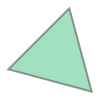

CPU times: user 271 ms, sys: 11.7 ms, total: 282 ms
Wall time: 320 ms


In [ ]:
#@title
%%time

sigma = 0.2
gamma = 1.6
Maxk  = 20

old_settings = np.geterr()
new_settings = {
    'divide':  'raise',
    'invalid': 'raise',
    'over':    'ignore',
    'under':   'ignore'
    }
settlist = ['old_settings','new_settings']
display(pd.DataFrame(
    list(map(eval, settlist)),
    index=settlist
    ))
"""
ignore: Take no action when the exception occurs.
warn: Print a RuntimeWarning (via the Python warnings module).
raise: Raise a FloatingPointError.
call: Call a function specified using the seterrcall function.
print: Print a warning directly to stdout.
log: Record error in a Log object specified by seterrcall.
"""

w = np.ones(Maxk)
b = np.ones(Maxk)
d = np.ones(Maxk)
b[-1] = 0
d[2] = 0
ps = np.array([list(p/sum(p)) for p in np.stack((w,b,d)).T])
ps[0:2][:] = np.zeros((2,3))

XZg = np.genfromtxt('../Gravity.tsv')
XZ = XZg[:,:2]
g  = XZg[:,-1]

XZmin = XZ
XZgrid = xz_iterp(XZ, np.r_[0:500:1001j])

InitModel = RegularModel(
    np.array([400, -100]),
    r=30,
    phi=-np.pi/4,
    n=3
    )

try:
  print('Init Model:\n')
  display_svg(Polygon(*map(Point, InitModel.copy())))
except:
  print('Error or Polygon has intersecting sides.')

Xi    = InitModel.gravitational(XZgrid)[:,(0,-1)]
Xgmin = XZg[:,(0,-1)]

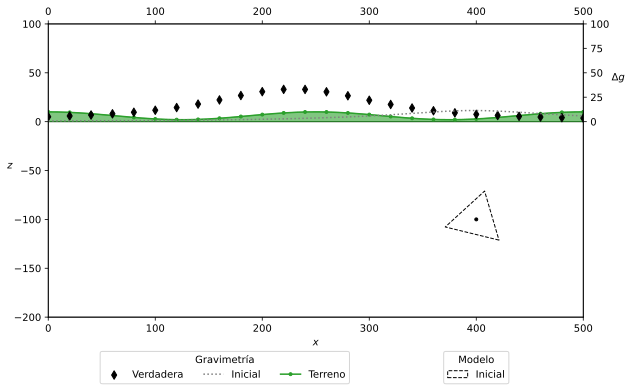

In [ ]:
#@markdown Plot in 1

fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
ax_z.axhline(c='k', lw=1, zorder=0)

lineg = ax_g.scatter(
    *Xgmin.T,
    marker='d',
    color='k',
    label='Verdadera'
    )

ax_g.plot(
    *Xi.T,
    linestyle=':',
    color='gray'
    )
linei = Line2D(
  [0],[0],
  linestyle=':',
  color='gray',
  label='Inicial'
  )

ax_z.plot(
    *XZgrid.T,
    color='tab:green',
    label='_nolegend_'
)
ax_z.fill_between(
    *XZgrid.T,
    color='tab:green',
    alpha=3/5
)
ax_z.scatter(
    *XZmin.T,
    marker='.',
    color='tab:green',
    label='_nolegend_'
)
linez = Line2D(
  [0],[0],
  marker='.',
  color='tab:green',
  label='Terreno'
  )
Initpoly = patches.Polygon(
    InitModel,
    closed=True,
    Fill=False,
    linestyle='--',
    edgecolor='k',
    label='Inicial'
    )
ax_z.add_patch(Initpoly)

ax_z.scatter(
    *InitModel.Cmass(),
    marker='.',
    color='k',
    zorder=2
    )

ax_z.set_xlabel(r'$x$')
ax_z.set_ylabel(r'$z$', rotation=0)
ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

ax_z.set_xlim(0, 500)
ax_z.set_ylim(ymin=-200)
ax_g.set_yticks(np.linspace(0, 100, 5))
align.yaxes(ax_z, 0, ax_g, 0, 2/3)

ax_g.legend(
    handles=[lineg, linei, linez],
    title='Gravimetría',
    bbox_to_anchor=(0.33, -.1),
    ncol=3,
    loc='upper center'
    )
ax_z.legend(
    handles=[Initpoly],
    title='Modelo',
    bbox_to_anchor=(0.8, -.1),
    ncol=2,
    loc='upper center'
    )
plt.savefig('InitPlot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@markdown RJMCMC
%%time

maxsteps = 5*10**3
miniters = 10

display(pd.DataFrame.from_dict(
    new_settings,
    orient='index',
    columns=['treatment']
    ).T)
print('Steps:')
start=dt.now()
with open('polygons.csv', 'w') as polygons,\
     open('itertimes.csv', 'w') as itertimes,\
     open('moves.csv', 'w') as moves,\
     open('errit.csv', 'w') as errit:
  pbar=tqdm(
      total=maxsteps,
      miniters=miniters,
      )
  loops=1
  steps=1
  errors=0
  oldtime=0
  polygons.write(str(InitModel.copy()) + '\n')
  moves.write('p\n')
  errit.write(f'{loops:d}\n')
  initk = len(InitModel)
  oldModel = InitModel
  oldi = rg.randint(initk)
  pbar.update(1)
  sys.stdout.write(
      f'\rErrors = {errors:07d}'+
      f'\tErrors/Loops = {errors/loops:.6f}'
      )
  while steps<maxsteps:
    loops += 1
    with np.errstate(**new_settings):
      try:
        alpha, newModel, newi, move = acceptanceTest(
            oldModel, oldi,
            XZ, g, ps,
            sigma=sigma,
            gamma=gamma
            )
        # Metropolis Condition and Shamos-Huey algorithm
        if rg.random()<min(1,alpha) and newModel.notintersect(): 
          polygons.write(str(newModel.copy()) + '\n')
          oldModel = newModel
          oldi     = newi
          moves.write(move + '\n')
          if steps%100==0:
            ittime = (dt.now()-start).total_seconds()
            itertimes.write(f'{ittime-oldtime:f}\n')
            oldtime = ittime
          steps += 1
          pbar.update(1)
      except FloatingPointError:
        errors += 1
        sys.stdout.write(
            f'\rErrors = {errors:07d}'+\
            f'\tErrors/Loops = {errors/loops:.6f}'
            )
        sys.stdout.flush()
        errit.write(f'{loops:d}\n')
  errit.write(f'{loops:d}\n')
  stop = dt.now()
  duration = (stop-start).total_seconds()
  itertimes.write(f'{duration-oldtime:f}\n')
  durationstr = dt.fromtimestamp(duration).strftime('%H:%M:%S.%f')
  polygons.close()
  itertimes.close()
  moves.close()
  errit.close()
pbar.close()
reject = loops  - steps
rejerr = reject - errors
print(
    f'\rErrors = {errors:07d}',
    f'\tErrors/Loops = {errors/loops:.6f}',
    end='\n')
print(
    f' Steps = {steps:07d}',
    f'\t Steps/Loops = {steps/loops:.6f}',
    end='\n')
print(f' Loops = {loops:07d}')
print(f'Reject = {reject:07d}')
print(f'Rejerr = {rejerr:07d}')
print(f'Tiempo:  {durationstr}')     

,divide,invalid,over,under
treatment,raise,raise,raise,raise


Steps:


  0%|          | 0/12000 [00:00<?, ?it/s]

Errors = 0040228 	Errors/Loops = 0.260367
 Steps = 0012000 	 Steps/Loops = 0.077667
 Loops = 0154505
Reject = 0142505
Rejerr = 0102277
Tiempo:  00:44:52.540594
CPU times: user 43min 56s, sys: 1min 4s, total: 45min
Wall time: 44min 52s


,Freq
Birth,565
Death,553
Simple,10882


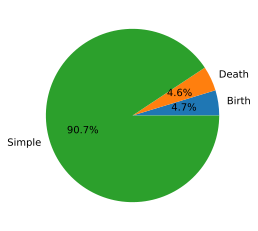

CPU times: user 164 ms, sys: 15.2 ms, total: 180 ms
Wall time: 190 ms


In [ ]:
#@markdown Moves freq

%%time

dfmoves = pd.read_csv(
    'moves.csv',
    header=None,
    names=['moves']
    )
movescounter = Counter(dfmoves['moves'])
new_keys = ['Simple','Birth','Death']
for oldkey, newkey in zip(movescounter.keys(), new_keys):
  movescounter[newkey] = movescounter.pop(oldkey)
dfmovesfreq = pd.DataFrame.from_dict(
    movescounter,
    orient='index',
    columns=['Freq']
    ).sort_index()
display(dfmovesfreq)
dfmovesfreq.plot.pie(y='Freq', autopct='%1.1f%%', legend=False)
plt.savefig('movesfreq.pdf', bbox_inches='tight')
plt.ylabel(None)
plt.show()

In [ ]:
#@markdown Numerical errors

%%time

erritfi = np.genfromtxt('errit.csv', delimiter='\n')
fig, ax = plt.subplots(1)
ax.bar(
    erritfi,
    np.ones_like(erritfi),
    width=10,
    color='k',
    alpha=.75
    )
ax.get_yaxis().set_visible(False)
#ax.set_rasterized(True)
ax.set_xlim(0, erritfi[-1])
ax.set_ylim(0, 1)
ax.set_xlabel('Trials')
plt.title('Numerical errors')
plt.savefig('errit.png', bbox_inches='tight', dpi=300)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

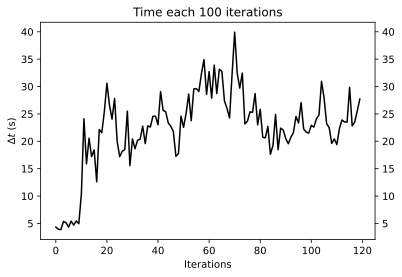

CPU times: user 1.07 s, sys: 37.1 ms, total: 1.1 s
Wall time: 1.16 s


In [ ]:
#@markdown Time each 100 iterations

%%time

dfitertimes = pd.read_csv(
    'itertimes.csv',
    header=None,
    names=['itertimes']
    )
fig, ax = plt.subplots(1)
ax.plot(
    dfitertimes,
    color='k'
    )
ax.tick_params(
    left=True,
    labelleft=True,
    right=True,
    labelright=True    
    )
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$\Delta{t}$ (s)')
plt.title('Time each 100 iterations')
plt.savefig('itertimes.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@markdown Walks

%%time

polygons = Model_from_file('polygons.csv')
lenp = len(polygons)
less = 1000
lesspolygons = [polygons[i] for i in range(0, lenp, int(lenp/less))]
InitModel = lesspolygons[0]
TestModel = lesspolygons[-1]
print('bigwalk:')
bigwalk = np.array([p.Cmass() for p in tqdm(polygons)])
print('biggeom:')
biggeom = np.array([p.Cgeom() for p in tqdm(polygons)])
print('walk:')
walk    = np.array([p.Cmass() for p in tqdm(lesspolygons)])
print('geom:')
geom    = np.array([p.Cgeom() for p in tqdm(lesspolygons)])

lenwalk  = len(walk)
points   = bigwalk.reshape(-1, 1, 2)
segments = np.concatenate(
    [points[:-1],
     points[1:]],
     axis=1)

lc = LineCollection(
    segments,
    cmap=plt.get_cmap('jet'),
    norm=plt.Normalize(0,lenwalk),
    zorder=2
    )
lc.set_array(np.arange(lenwalk))
lc.set_linewidth(2)
#lc.set_rasterized(True)

fig, ax = plt.subplots(1)
ax.scatter(
    *InitModel.Cmass(),
    marker='o',
    color='k',
    zorder=2
    )
ax.plot(
    *bigwalk.T,
    color='k',
    alpha=0,
    zorder=0,
    )
ax.plot(
    *biggeom.T,
    color='k',
    alpha=0.2,
    zorder=0,
    )
# ax.scatter(
#     *TrueModel.Cmass(),
#     marker='x',
#     color='r',
#     zorder=2
#     )
# ax.scatter(
#     *TrueModel.Cgeom(),
#     marker='x',
#     color='gray',
#     zorder=2
#     )
ax.tick_params(
    bottom=True,
    labelbottom=True,
    top=True,
    labeltop=True,
    left=True,
    labelleft=True,
    right=True,
    labelright=True    
    )
ax.add_collection(lc)
ax.set_xlabel('x')
ax.set_ylabel('z', rotation=0)
plt.title('Recorrido de Caminos')
plt.savefig('walk.pdf', bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

kaes:


  0%|          | 0/12000 [00:00<?, ?it/s]

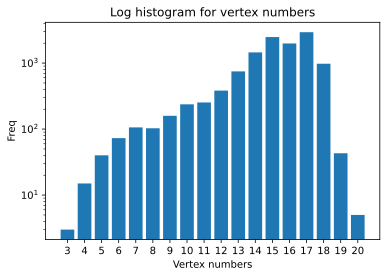

CPU times: user 2 s, sys: 54.3 ms, total: 2.05 s
Wall time: 2.18 s


In [ ]:
#@markdown Log histogram for vertex numbers

%%time

print('kaes:')
kaes = [len(TestModel) for TestModel in tqdm(polygons)]

plt.bar(*zip(*Counter(kaes).items()))
plt.xticks(np.arange(3, Maxk+1))
plt.yscale('log')
plt.title('Log histogram for vertex numbers')
plt.xlabel('Vertex numbers')
plt.ylabel('Freq')
plt.savefig('hist.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@markdown Vertex Numbers Evolution

%%time

koc = np.delete(
        np.dstack(
          (kaes, np.roll(kaes, -1))),
          -1, axis=1
          )
df = pd.DataFrame(
    *koc,
    columns=['open','close']
    )
df['low']  = np.fromiter(map(np.amin, *koc), dtype=np.int)
df['high'] = np.fromiter(map(np.amax, *koc), dtype=np.int)
df.to_csv('kaes.csv')

fig = go.Figure(
    data=[go.Candlestick(
      x=df.index,
      open=df.open,
      high=df.high,
      low=df.low,
      close=df.close
    )])

fig.update_layout(
    template='plotly_white',
    margin=go.layout.Margin(
        l=1, #left margin
        r=1, #right margin
        b=1, #bottom margin
        t=26 #top margin
    ),
    width=800,
    height=450,
    title='Vertex Numbers Evolution',
    title_x=0.5,
    xaxis_title='Iterations',
    yaxis_title='vertex numbers',
    yaxis=dict(
        range=[3, Maxk],
        tickmode='linear',
        tick0=3,
        dtick=1
        ),
    xaxis_rangeslider_visible=False,
    )
fig.write_image('kaes.pdf')
fig.show()

CPU times: user 501 ms, sys: 72.4 ms, total: 574 ms
Wall time: 4.12 s


likehood:


  0%|          | 0/12000 [00:00<?, ?it/s]

priorden:


  0%|          | 0/12000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2432: RuntimeWarning:

underflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:6849: RuntimeWarning:

underflow encountered in power

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:2471: RuntimeWarning:

underflow encountered in power

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:1106: RuntimeWarning:

underflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:2471: RuntimeWarning:

underflow encountered in power

/usr/local/lib/python3.7/dist-packages/matplotlib/ticker.py:1106: RuntimeWarning:

underflow encountered in double_scalars



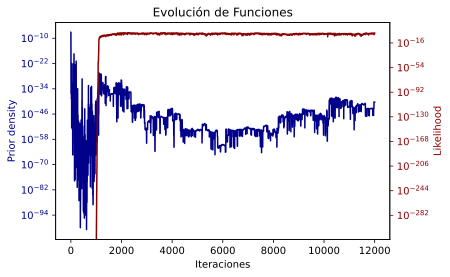

CPU times: user 1min 34s, sys: 2.9 s, total: 1min 37s
Wall time: 1min 35s


In [ ]:
#@markdown Likelihood and Prior density Evolution

%%time

print('likehood:')
likehood = [Likelihood(TestModel, XZ, g, sigma=sigma)\
  for TestModel in tqdm(polygons)]
print('priorden:')
priorden = [Prior_density(TestModel, gamma=gamma)\
  for TestModel in tqdm(polygons)]
   
try:
  with np.errstate(all='warn'):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    # https://stackoverflow.com/a/3513150
    # ax1.set_yscale('symlog')
    ax1.set_yscale('log', nonposy='mask')
    # ax2.set_yscale('symlog')
    ax2.set_yscale('log', nonposy='mask')
    c1='darkblue'
    c2='darkred'
    ax1.plot(
        priorden,
        color=c1
        )
    ax2.plot(
        likehood,
        color=c2
        )
    ax1.tick_params(
        axis='y',
        colors=c1
        )
    ax2.tick_params(
        axis='y',
        colors=c2
        )
    ax1.set_xlabel(
        'Iteraciones'
        )
    ax1.set_ylabel(
        'Prior density',
        color=c1
        )
    ax2.set_ylabel(
        'Likelihood',
        color=c2
        )
    plt.title('Evolución de Funciones')
    plt.savefig('evolution.pdf', bbox_inches='tight')
    plt.show()
except:
  print('Error')

bigwalk:


  0%|          | 0/12000 [00:00<?, ?it/s]

biggeom:


  0%|          | 0/12000 [00:00<?, ?it/s]

walk:


  0%|          | 0/1000 [00:00<?, ?it/s]

geom:


  0%|          | 0/1000 [00:00<?, ?it/s]

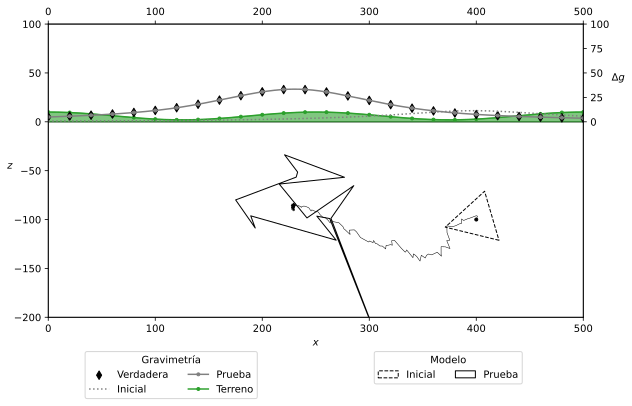

CPU times: user 7.32 s, sys: 1.75 s, total: 9.07 s
Wall time: 7.36 s


In [ ]:
#@markdown Plot out 1
%%time

polygons = Model_from_file('polygons.csv')
lenp = len(polygons)
less = 1000
lesspolygons = [polygons[i] for i in range(0, lenp, int(lenp/less))]
InitModel = lesspolygons[0]
TestModel = lesspolygons[-1]
print('bigwalk:')
bigwalk = np.array([p.Cmass() for p in tqdm(polygons)])
print('biggeom:')
biggeom = np.array([p.Cgeom() for p in tqdm(polygons)])
print('walk:')
walk    = np.array([p.Cmass() for p in tqdm(lesspolygons)])
print('geom:')
geom    = np.array([p.Cgeom() for p in tqdm(lesspolygons)])


fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
ax_z.axhline(c='k', lw=1, zorder=0)

Xy    = lesspolygons[-1].gravitational(XZgrid)[:,(0,-1)]
Xymin = lesspolygons[-1].gravitational(XZmin)[:,(0,-1)]

lineg = ax_g.scatter(
    *Xgmin.T,
    marker='d',
    color='k',
    label='Verdadera'
    )

ax_g.plot(
    *Xi.T,
    linestyle=':',
    color='gray'
    )
linei = Line2D(
  [0],[0],
  linestyle=':',
  color='gray',
  label='Inicial'
  )

ax_g.plot(
    *Xy.T,
    color='gray'
    )
ax_g.scatter(
    *Xymin.T,
    marker='.',
    color='gray',
    label='_nolegend_'
    )
liney = Line2D(
  [0],[0],
  marker='.',
  color='gray',
  label='Prueba'
  )

ax_z.plot(
    *XZgrid.T,
    color='tab:green',
    label='_nolegend_'
)
ax_z.fill_between(
    *XZgrid.T,
    color='tab:green',
    alpha=3/5
)
ax_z.scatter(
    *XZmin.T,
    marker='.',
    color='tab:green',
    label='_nolegend_'
)
linez = Line2D(
  [0],[0],
  marker='.',
  color='tab:green',
  label='Terreno'
  )

Initpoly = patches.Polygon(
    lesspolygons[0],
    closed=True,
    Fill=False,
    linestyle='--',
    edgecolor='k',
    label='Inicial'
    )
ax_z.add_patch(Initpoly)

Testpoly = patches.Polygon(
    lesspolygons[-1],
    closed=True,
    Fill=False,
    edgecolor='k',
    label='Prueba'
    )
ax_z.add_patch(Testpoly)

ax_z.scatter(
    *lesspolygons[0].Cmass(),
    marker='.',
    color='k',
    zorder=2
    )
ax_z.plot(
    *walk.T,
    linewidth=0.5,
    color='k',
    )

ax_z.set_xlabel(r'$x$')
ax_z.set_ylabel(r'$z$', rotation=0)
ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

ax_z.set_xlim(0, 500)
ax_z.set_ylim(ymin=-200)
ax_g.set_yticks(np.linspace(0, 100, 5))
align.yaxes(ax_z, 0, ax_g, 0, 2/3)


ax_g.legend(
    handles=[lineg, linei, liney, linez],
    title='Gravimetría',
    bbox_to_anchor=(.4, -.1),
    ncol=2,
    loc='upper right'
    )
ax_z.legend(
    handles=[Initpoly, Testpoly],
    title='Modelo',
    bbox_to_anchor=(.6, -.1),
    ncol=2,
    loc='upper left'
    )
plt.savefig('Plot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@markdown Video 1
%%time

fps = 30
print(f'Graficando cada fotograma, puede tardar un tiempo...')
fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5, dpi=300)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
camera=Camera(fig)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
for i, TestModel in tqdm(
    enumerate(lesspolygons),
    total=len(lesspolygons),
    miniters=10
    ):
  ax_z.axhline(c='k', lw=1, zorder=0)
  
  Xy    = TestModel.gravitational(XZgrid)[:,(0,-1)]
  Xymin = TestModel.gravitational(XZmin)[:,(0,-1)]


  lineg = ax_g.scatter(
      *Xgmin.T,
      marker='d',
      color='k',
      label='Verdadera'
      )

  ax_g.plot(
      *Xi.T,
      linestyle=':',
      color='gray'
      )
  linei = Line2D(
    [0],[0],
    linestyle=':',
    color='gray',
    label='Inicial'
    )

  ax_g.plot(
      *Xy.T,
      color='gray'
      )
  ax_g.scatter(
      *Xymin.T,
      marker='.',
      color='gray',
      label='_nolegend_'
      )
  liney = Line2D(
    [0],[0],
    marker='.',
    color='gray',
    label='Prueba'
    )

  ax_z.plot(
      *XZgrid.T,
      color='tab:green',
      label='_nolegend_'
  )
  ax_z.fill_between(
      *XZgrid.T,
      color='tab:green',
      alpha=3/5
  )
  ax_z.scatter(
      *XZmin.T,
      marker='.',
      color='tab:green',
      label='_nolegend_'
  )
  linez = Line2D(
    [0],[0],
    marker='.',
    color='tab:green',
    label='Terreno'
    )

  Initpoly = patches.Polygon(
      lesspolygons[0],
      closed=True,
      Fill=False,
      linestyle='--',
      edgecolor='k',
      label='Inicial'
      )
  ax_z.add_patch(Initpoly)

  Testpoly = patches.Polygon(
      TestModel,
      closed=True,
      Fill=False,
      edgecolor='k',
      label='Prueba'
      )
  ax_z.add_patch(Testpoly)

  ax_z.scatter(
      *lesspolygons[0].Cmass(),
      marker='.',
      color='k',
      zorder=2
      )
  ax_z.plot(
      *walk[:i].T,
      linewidth=0.5,
      color='k',
      )

  ax_z.set_xlabel(r'$x$')
  ax_z.set_ylabel(r'$z$', rotation=0)
  ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

  ax_z.set_xlim(0, 500)
  ax_z.set_ylim(ymin=-200)
  ax_g.set_yticks(np.linspace(0, 100, 5))
  align.yaxes(ax_z, 0, ax_g, 0, 2/3)

  ax_g.legend(
      handles=[lineg, linei, liney, linez],
      title='Gravimetría',
      bbox_to_anchor=(.4, -.1),
      ncol=2,
      loc='upper right'
      )
  ax_z.legend(
      handles=[Initpoly, Testpoly],
      title='Modelo',
      bbox_to_anchor=(.6, -.1),
      ncol=2,
      loc='upper left'
      )
  plt.tight_layout(w_pad=0, h_pad=1)
  camera.snap()
plt.close()
animation=camera.animate(interval=less/fps, repeat=False)
#interval: Delay between frames in milliseconds. Defaults to 200.
filename='video.mp4'
start=dt.now()
print(f'Guardando el archivo {filename}, puede tardar un tiempo...')
pbar=tqdm(total=less)
animation.save(filename, progress_callback=\
               lambda i, n: pbar.update(1)
               )
pbar.close()
stop=dt.now()
videoduration=int((stop-start).total_seconds())
videodurationstr=dt.fromtimestamp(videoduration).strftime('%M:%S')
print(f'Archivo {filename} Guardado!\n Tiempo: {videodurationstr}')
showvideo(filename)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@markdown Archivo `.zip`

!rm -f zfiles.zip
!7z a -bso0 ../{workdir}.zip *.* -x!*.zip
!7z l ../{workdir}.zip

  0M Scan             0%     16% 14 + polygons.csv                       37% 14 + polygons.csv                       55% 16 + video.mp4                    93% 17 + walk.pdf                  
7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../             1 file, 3184360 bytes (3110 KiB)

Listing archive: ../Serialpc_211122-2105_9fec.zip

--
Path = ../Serialpc_211122-2105_9fec.zip
Type = zip
Physical Size = 3184360

   Date      Time    Attr         Size   Compressed  Name
------------------- ----- ------------ ------------  ------------------------
2021-11-23 02:07:09 .....        2937